In [ ]:
!pip uninstall -y -q numpy opencv-python opencv-contrib-python opencv-python-headless gcsfs fsspec


# 호환 버전 재설치
!pip install -q numpy==1.26.4 fsspec==2024.5.0 gcsfs==2024.5.0
!pip install -q opencv-python-headless==4.10.0.84


# PyTorch (CPU 빌드) + 필수 라이브러리
!pip install -q torch==2.3.1 torchvision==0.18.1 torchaudio==2.3.1 --index-url https://download.pytorch.org/whl/cpu
!pip install -q diffusers==0.30.0 transformers==4.43.3 accelerate==0.33.0 \
safetensors==0.4.3 datasets==2.20.0 ftfy==6.2.0 einops==0.8.0


import os, shutil, glob, math, random
from pathlib import Path
import torch


print('Torch version:', torch.__version__)
print('CUDA available:', torch.cuda.is_available())
print('Device:', 'GPU: ' + torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'CPU only')

In [ ]:
!pip install -q "transformers==4.45.2" "huggingface_hub>=0.24.6"
import os; os.kill(os.getpid(), 9)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 40.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 45.0 MB/s eta 0:00:00


In [ ]:
import transformers, diffusers, torch, numpy
print("transformers:", transformers.__version__)   # 기대: 4.45.2
print("diffusers:", diffusers.__version__)         # 기대: 0.30.0
print("torch:", torch.__version__)                 # 2.3.1+cpu (또는 +cuXXX)
print("numpy:", numpy.__version__)                 # 1.26.4

transformers: 4.45.2
diffusers: 0.30.0
torch: 2.3.1+cpu
numpy: 1.26.4


In [ ]:
from pathlib import Path
WS = Path('/content/sd_lora_oldmasters')
DS_DIR = WS / 'dataset'
OUT_DIR = WS / 'outputs'
WEIGHTS_DIR = WS / 'weights'
INFER_INPUTS = WS / 'infer_inputs'
for p in [WS, DS_DIR, OUT_DIR, WEIGHTS_DIR, INFER_INPUTS]:
  p.mkdir(parents=True, exist_ok=True)


MODEL_NAME = 'runwayml/stable-diffusion-v1-5'
INSTANCE_TOKEN = 'omstyle'
CLASS_TOKEN = 'painting'

CUDA available: False


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion_img2img.StableDiffusionImg2ImgPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


  0%|          | 0/6 [00:00<?, ?it/s]

saved -> /content/sd_lora_oldmasters/outputs/image_om_demo.png


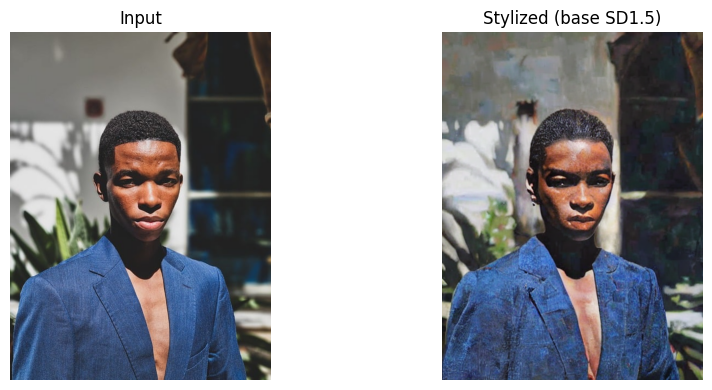

In [ ]:
from diffusers import StableDiffusionImg2ImgPipeline
from PIL import Image
import matplotlib.pyplot as plt
import torch


USE_CUDA = torch.cuda.is_available()
print('CUDA available:', USE_CUDA)


pipe = StableDiffusionImg2ImgPipeline.from_pretrained(
    MODEL_NAME,
    torch_dtype=(torch.float16 if USE_CUDA else torch.float32),
    safety_checker=None,
)
pipe.to('cuda' if USE_CUDA else 'cpu')

if USE_CUDA:
    # GPU일 때만 오프로딩/메모리 절약 기능 사용
    try:
        pipe.enable_sequential_cpu_offload()
    except Exception:
        pass
else:
    # CPU일 땐 이 정도만: attention slicing은 CPU에서도 OK
    pipe.enable_attention_slicing()
    # CPU에서는 enable_sequential_cpu_offload() 호출 금지


POS_PROMPT = f"oil painting, old masters, textured canvas, chiaroscuro"
NEG_PROMPT = "lowres, blurry, cartoon, extra fingers, watermark"
STRENGTH = 0.45
GUIDANCE = 6.5 if not USE_CUDA else 7.5
NUM_STEPS = 15 if not USE_CUDA else 30


images = [p for p in INFER_INPUTS.glob('*') if p.suffix.lower() in {'.jpg','.jpeg','.png','.webp'}]
assert images, f"테스트 이미지를 {INFER_INPUTS} 에 넣어주세요"


vis = []
for p in images[:4]:
    src = Image.open(p).convert('RGB')
    out = pipe(prompt=POS_PROMPT, negative_prompt=NEG_PROMPT, image=src,
    strength=STRENGTH, guidance_scale=GUIDANCE, num_inference_steps=NUM_STEPS).images[0]
    save_path = OUT_DIR / f"{p.stem}_om_demo.png"
    out.save(save_path)
    print('saved ->', save_path)
    vis.append((src, out))


# 시각화
cols = 2
rows = len(vis)
plt.figure(figsize=(10, 4*rows))
for i, (a,b) in enumerate(vis):
  plt.subplot(rows, cols, 2*i+1); plt.imshow(a); plt.axis('off'); plt.title('Input')
  plt.subplot(rows, cols, 2*i+2); plt.imshow(b); plt.axis('off'); plt.title('Stylized (base SD1.5)')
plt.tight_layout(); plt.show()